## Load libraries

In [1]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as T
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.5
1.0.2


## define colors

In [2]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

# Section 3.3

Build a model that generates Poisson counts

## Build a generative model

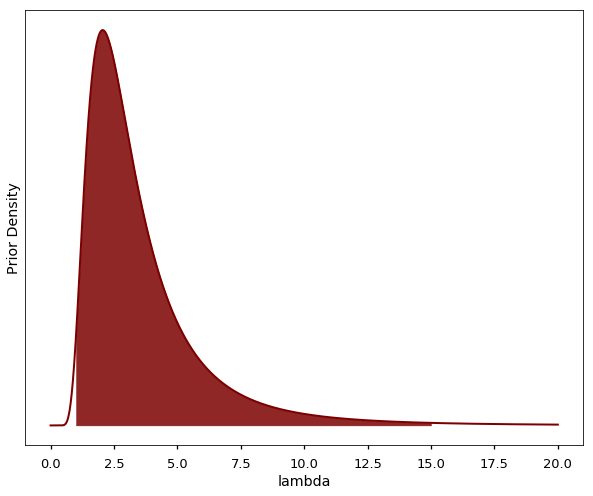

In [6]:
lbda  = np.linspace(0, 20, num=int(20/0.001))
pdf = stats.invgamma(3.48681,scale=9.21604)
plt.plot(lbda, pdf.pdf(lbda), c=c_dark_highlight, lw=2)
plt.xlabel("lambda"); plt.ylabel("Prior Density"); plt.yticks([]);


lbda99 = np.linspace(1, 15, num=int(15/0.001))



plt.fill_between(lbda99,0.,y2=pdf.pdf(lbda99),color=c_dark)

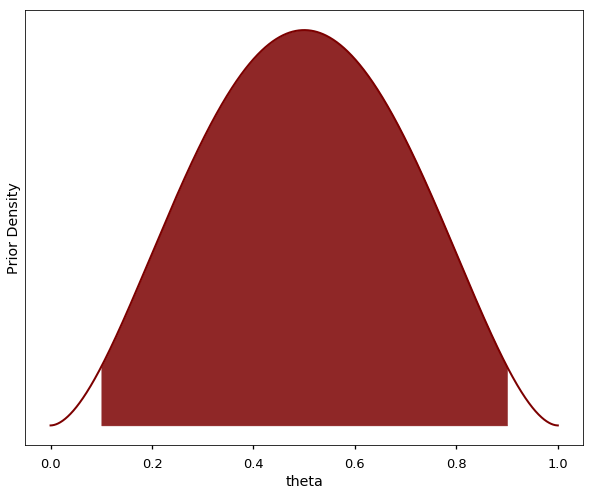

In [8]:
theta  = np.linspace(0, 1, num=int(1/0.001))
pdf = stats.beta(2.8663,2.8663)
plt.plot(theta, pdf.pdf(theta), c=c_dark_highlight, lw=2)
plt.xlabel("theta"); plt.ylabel("Prior Density"); plt.yticks([]);


theta99 = np.linspace(0.1, 0.9, num=int(0.8/0.001))



plt.fill_between(theta99,0.,y2=pdf.pdf(theta99),color=c_dark)

In [66]:
#WORKING

model = pm.Model()
N = 1000
R = 1000
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    theta = pm.Beta("theta",alpha=2.8663,beta=2.8663)
    
    y = pm.ZeroInflatedPoisson("y",psi=theta,theta=lbda,shape=N)
    

In [67]:
# Note this breaks when N != R
with model:
    trace = pm.sample_prior_predictive(samples=R)

In [68]:
simu_lbdas = trace['lbda']
simu_thetas = trace['theta']
simu_ys = trace['y']

## Plot prior predictive distribution

In [74]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, simu_ys)

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

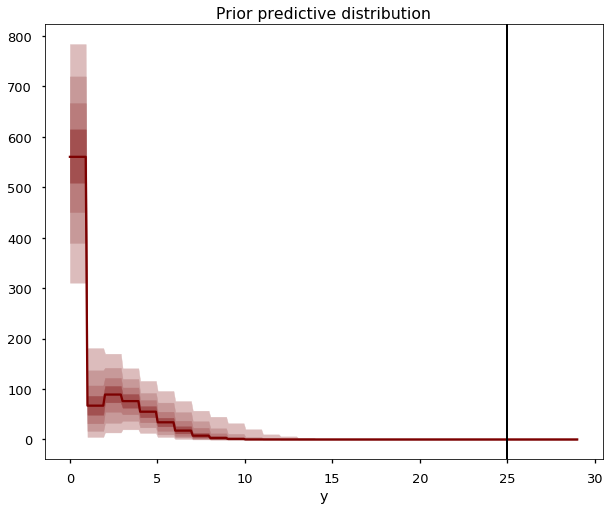

In [76]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Prior predictive distribution');

## Fit to simulated data

In example Betancourt performs this for each `y` in trace. Here we just do it for one.

In [80]:
model = pm.Model()
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    theta = pm.Beta("theta",alpha=2.8663,beta=2.8663)
    
    y = pm.ZeroInflatedPoisson("y",psi=theta,theta=lbda,shape=N,observed=simu_ys[:,-1])
    
    trace = pm.sample(draws=R,tune=4*R)
   

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, lbda]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1599.00draws/s]


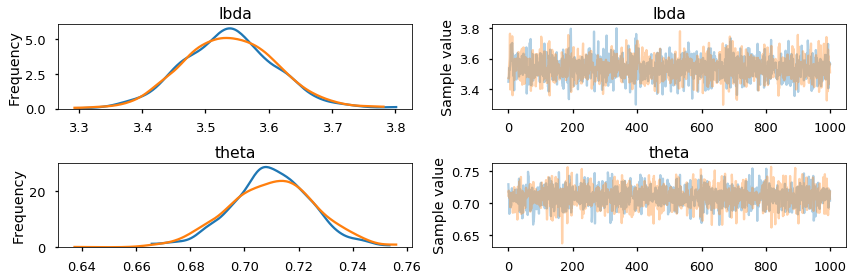

In [81]:
pm.plots.traceplot(trace);

In [82]:
# Compute rank of prior draw with respect to thinned posterior draws
sbc_rank = np.sum(simu_lbdas < trace['lbda'][::2])



In [83]:
# posterior sensitivities analysis
s = pm.stats.summary(trace,varnames=['lbda'])
post_mean_lbda = s['mean'].values
post_sd_lbda = s['sd'].values
prior_sd_lbda = 6.44787
z_score = np.abs((post_mean_lbda - simu_lbdas) / post_sd_lbda)
shrinkage = 1 - (post_sd_lbda / prior_sd_lbda ) ** 2

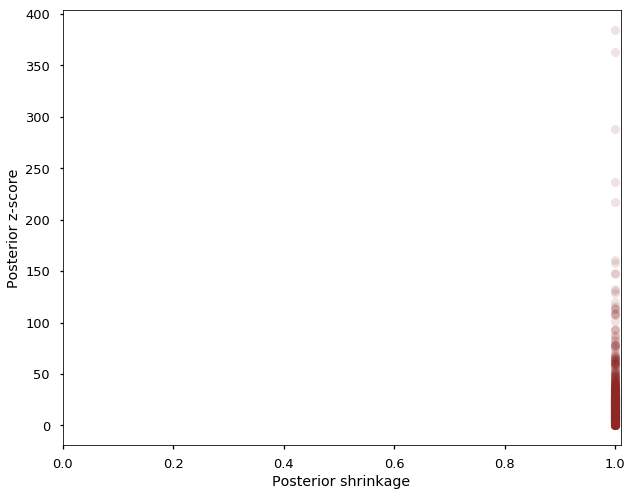

In [84]:
plt.plot(shrinkage[0]*np.ones(len(z_score)),z_score,'o',c="#8F272720");
plt.xlim(0,1.01); plt.xlabel('Posterior shrinkage'); plt.ylabel('Posterior z-score');

## Fit observations and evaluate

In [85]:
df = pd.read_csv('data.csv')
data_ys = df[df['data']=='y']['value'].values

In [86]:
model = pm.Model()
with model:
    lbda = pm.InverseGamma("lbda",alpha=3.48681,beta=9.21604)
    theta = pm.Beta("theta",alpha=2.8663,beta=2.8663)
    
    y = pm.ZeroInflatedPoisson("y",psi=theta,theta=lbda,shape=N,observed=data_ys)
    
    trace = pm.sample(draws=R,tune=4*R,chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta, lbda]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:12<00:00, 1581.64draws/s]


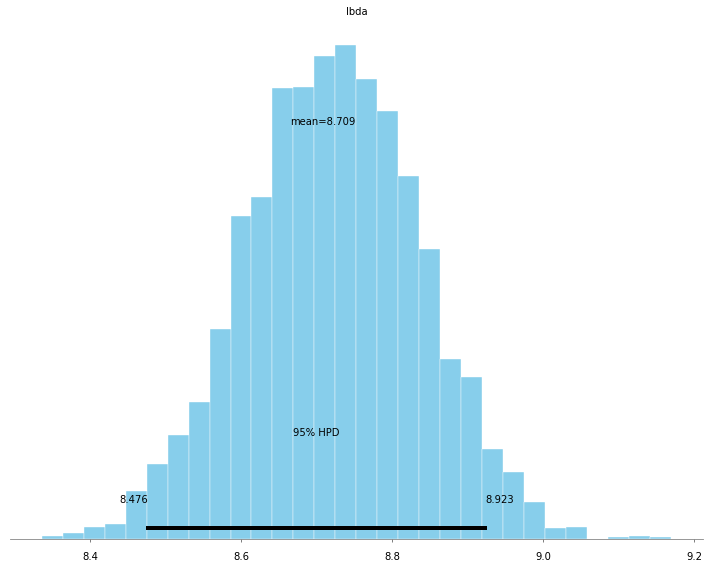

In [87]:
pm.plots.plot_posterior(trace,varnames=['lbda']);

In [88]:
with model:
     ppc = pm.sample_ppc(trace)

100%|██████████| 1000/1000 [00:00<00:00, 1262.27it/s]


In [90]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

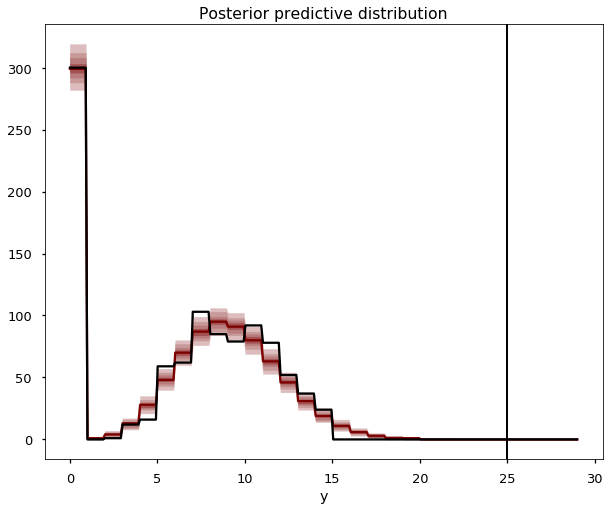

In [91]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');